# Find origin of inheritance.
input phased VCF and coordinates

<IPython.core.display.Javascript object>


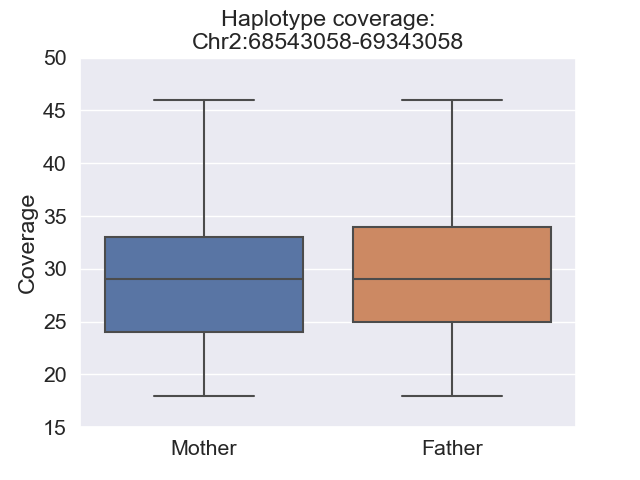

<IPython.core.display.Javascript object>


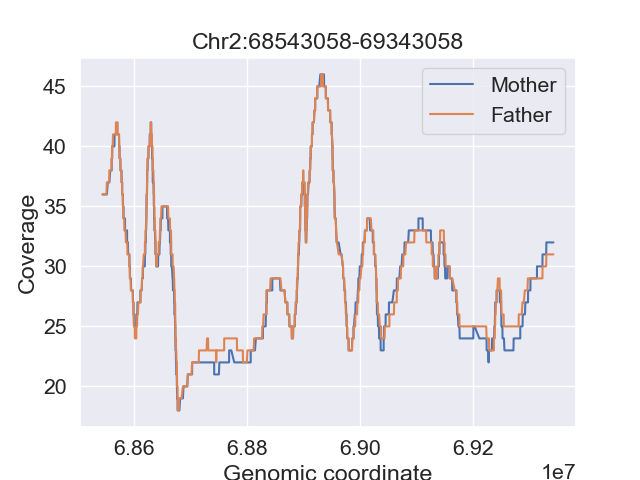

<IPython.core.display.Javascript object>


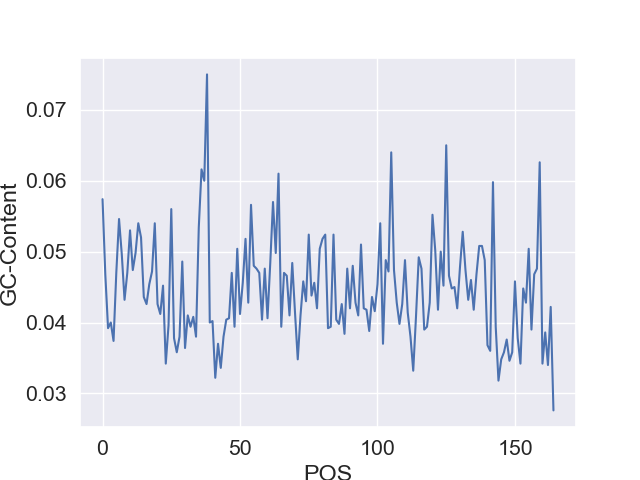

<IPython.core.display.Javascript object>


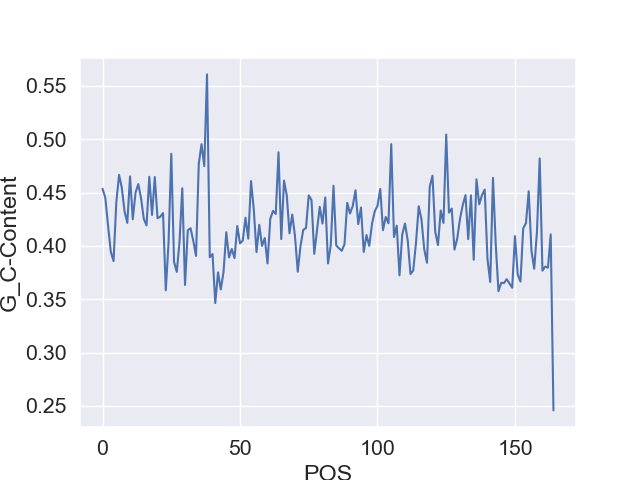

<IPython.core.display.Javascript object>


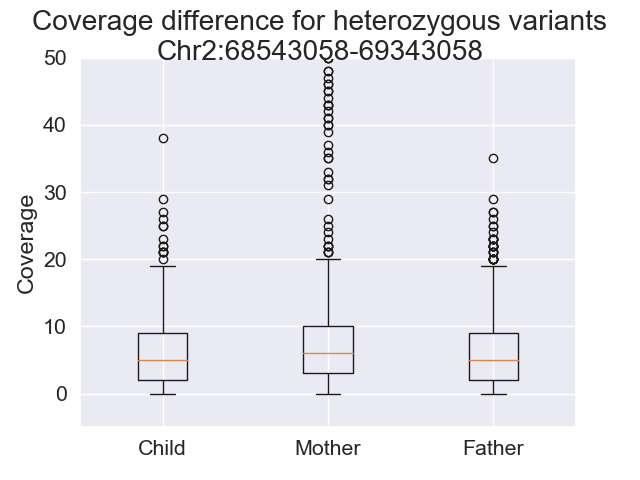

<IPython.core.display.Javascript object>


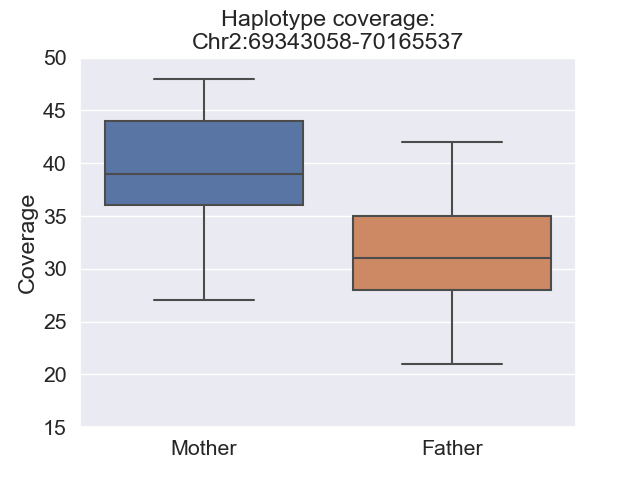

<IPython.core.display.Javascript object>


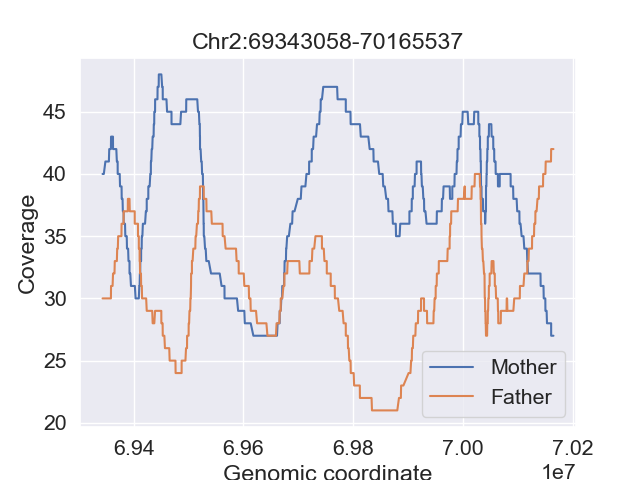

<IPython.core.display.Javascript object>


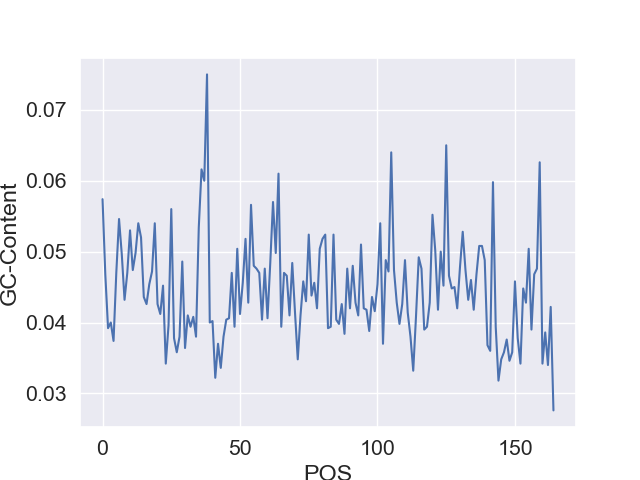

<IPython.core.display.Javascript object>


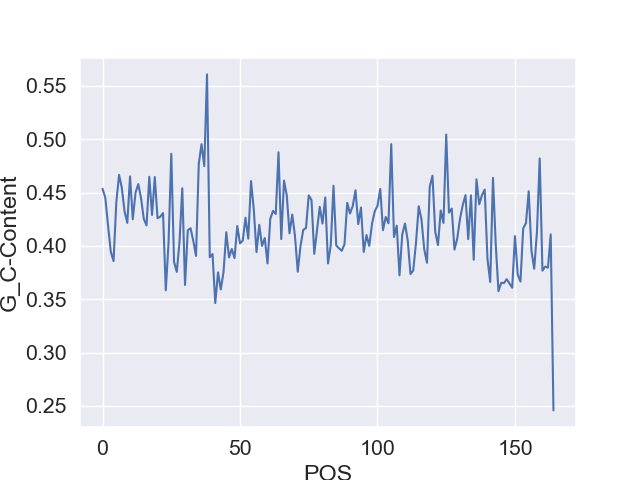

<IPython.core.display.Javascript object>


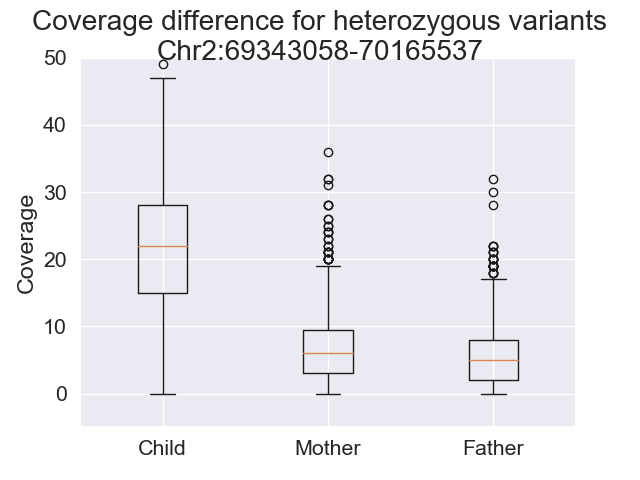

<IPython.core.display.Javascript object>


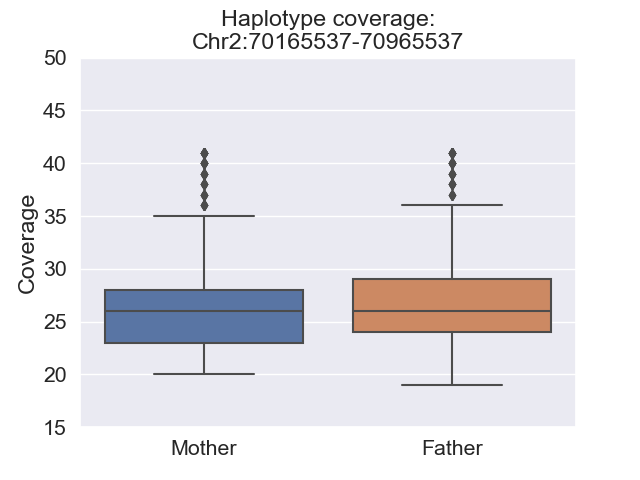

<IPython.core.display.Javascript object>


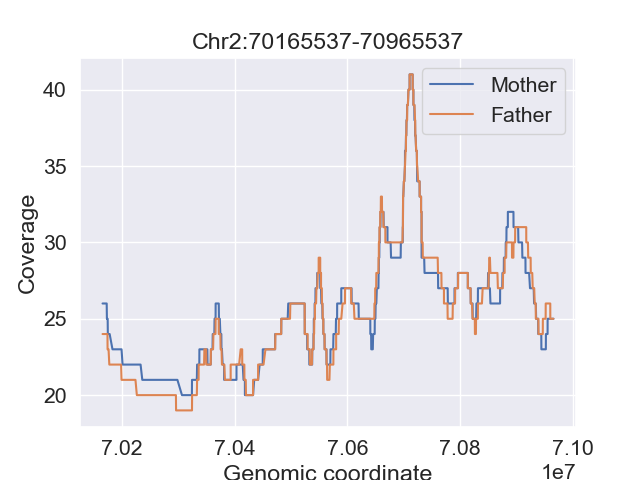

<IPython.core.display.Javascript object>


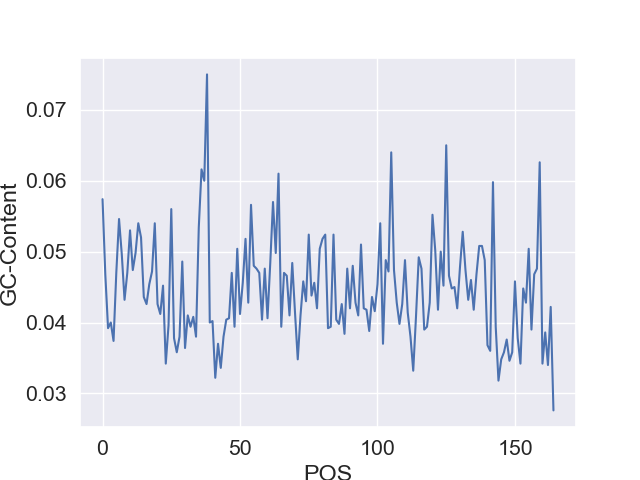

<IPython.core.display.Javascript object>


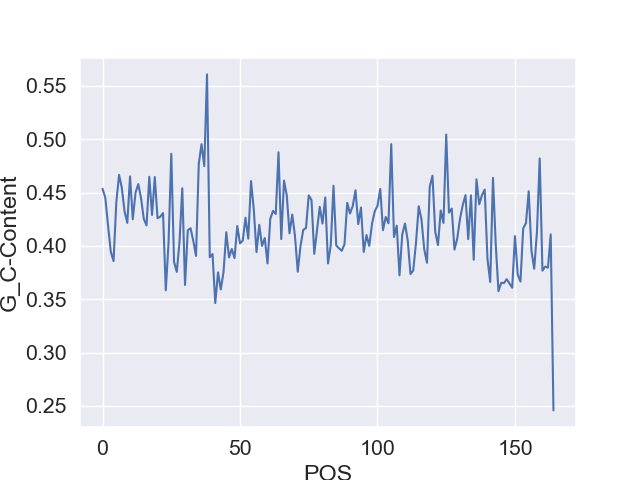

<IPython.core.display.Javascript object>


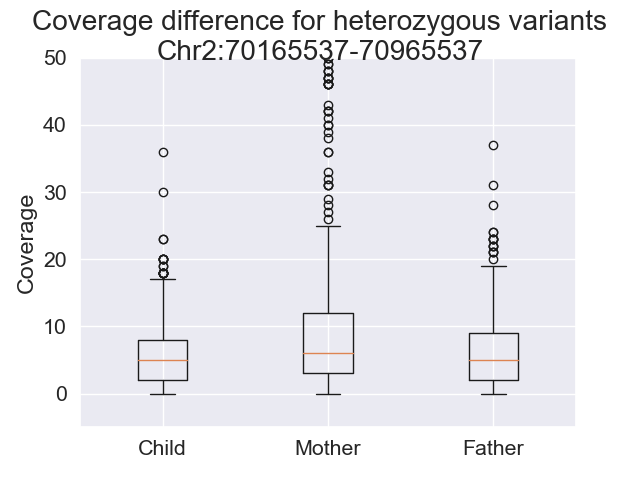

In [91]:
%matplotlib notebook
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LogNorm
import os.path
from scipy.ndimage import gaussian_filter1d




def smoothing(arr,case,ARGS):
    if case == "linear":
        no_var = len(arr)
        k = ARGS[0]
        arr_kernel = list(arr [:k-1])
        summ = sum(arr[:k - 1])
        for i in range(k-1,no_var):
            summ += arr[i]
            arr_kernel += [summ/float(k)]
            summ -= arr [i-k+1]
        return list(arr_kernel)
    elif case == 'gaussian':
        sigma = ARGS[0]
        return gaussian_filter1d (arr,sigma)

    
for whereLocated in range(-1,2):
    if whereLocated == 0:
        chromosome = '2' 
        begining = '69343058'
        end = '70165537'
    elif whereLocated == -1:
        chromosome = '2' 
        begining = str(69343058-800000)
        end = '69343058'
    elif whereLocated == 1:
        chromosome = '2' 
        begining = '70165537'
        end = str(70165537+800000)


    plt.figure()

    coordinate = chromosome + ":" + begining + "-" + end
    coordinate_string = 'Chr'+coordinate
    vcffile = '/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/brusco_uwcmg_eho_1.HF.final.phased.vcf.gz'
    tmp_outfile = '/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/ANALYSIS/temp.txt'

    which_individual = 'child'
    if which_individual == 'child':
        Var_which_individual = 10
    elif which_individual == 'father':
        Var_which_individual = 11
    elif which_individual == 'mother':
        Var_which_individual = 12


    command_read_data = "bcftools view -H " + vcffile + " " + \
        coordinate + " | cut -f 2,"+ str(Var_which_individual) + " | cut -f 1,2 -d: | tr ':' '\t' > " + tmp_outfile

    os.system(command_read_data)

    poses, mother, father = [] , [] ,  []

    for l  in open(tmp_outfile).readlines():
        pos,g,d = l.split()
        if g[1] == "|":
            G = g.split("|")
            D = d.split(',')
            poses += [int(pos)]
            mother += [int(D[int(G[0])])]
            father += [int(D[int(G[1])])]

    m_smoothed_gaussian =  smoothing(mother,'gaussian',[20])
    f_smoothed_gaussian =  smoothing(father,'gaussian',[20])

    m_smoothed_linear =  smoothing(mother,'linear',[5])
    f_smoothed_linear =  smoothing(father,'linear',[5])







    y_lim = (15,50)

    mp = {'POS':poses,'Father(raw)':father,'Mother(raw)':mother,'Father':f_smoothed_gaussian, 'Mother':m_smoothed_gaussian,\
          'M Smoothed Linear':m_smoothed_linear,'F Smoothed Linear': f_smoothed_linear}
    df = pd.DataFrame(mp)
    sn.set(font_scale = 1.4)
    ax = sn.boxplot(data=df[['Mother',"Father"]])


    ax.set_title('Haplotype coverage:\n' + coordinate_string)
    ax.set_ylabel('Coverage')
    ax.set_ylim(y_lim)


    plt.savefig('coverage_box'+coordinate_string,dpi=1000,format='png')









    #sn.boxplot(data=df[['M',"F",'M S G','F S G','M S L','F S L']])

    fig = plt.figure() 
    ax = sn.lineplot(x='POS',y='Mother',data=df,label = 'Mother')
    ax = sn.lineplot(x='POS',y='Father',data=df, ax =ax,label = 'Father')
    ax.set_title('Chr'+coordinate)
    ax.set_xlabel('Genomic coordinate')
    ax.set_ylabel('Coverage')
    ax.legend()

    os.system('rm ' + tmp_outfile)


    plt.figure()

    bin_size = 5000

    seq = ""
    for l in open("/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/chr2_69343058_70165537.fasta").readlines():
        if l[0] != ">":
            seq += l.rstrip()
    is_gc = [0] * (len(seq)/bin_size + 1)
    is_g_or_c = [0] * (len(seq)/bin_size + 1)
    for i in range(len(seq)-1):
        if seq[i:i+2].lower() == "gc":
            is_gc[int(i/bin_size)] += 1
        if seq[i].lower() in ["g","c"]:
            is_g_or_c[int(i/bin_size)] += 1

    df = pd.DataFrame({'POS': range(len(is_gc)), 'Number of GC': is_gc,"G or C" : is_g_or_c})
    df['GC-Content'] = df['Number of GC'] / bin_size

    ax = sn.lineplot(x='POS',y='GC-Content',data=df,label = '')

    plt.figure()
    df['G_C-Content'] = df['G or C'] / bin_size
    ax = sn.lineplot(x='POS',y='G_C-Content',data=df,label = '')





    vcffile = '/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/brusco_uwcmg_eho_1.HF.final.phased.vcf.gz'
    tmp_outfile = '/confidential/FamilyR13_data/moeinzadeh/ossifican_progressiva/ANALYSIS/temp2.txt'

    command_read_data = "bcftools view -H  " + vcffile + " " + \
        coordinate + " | cut -f 2,10,11,12  | tr '\t' ':' | cut -d: -f1,2,3,7,8,12,13 | tr ':' '\t' > " + tmp_outfile

    os.system(command_read_data)

    l_child = []
    l_father = []
    l_mother = []

    for l in open(tmp_outfile).readlines():
        a = l.split()
        if a[1][0] != a[1][2]:
            l_child += [abs(int(a[2].split(',')[0]) - int(a[2].split(',')[1]) )]
        if a[3][0] != a[3][2]:
            l_father += [abs(int(a[4].split(',')[0]) - int(a[4].split(',')[1]) )]
        if a[5][0] != a[5][2]:
            l_mother += [abs(int(a[6].split(',')[0]) - int(a[6].split(',')[1]) )]



    ylim = (-5,50)        
    fig = plt.figure()
    fig.suptitle('Coverage difference for heterozygous variants\n' + coordinate_string )
    ax = plt.gca()
    ax.set_ylim(ylim)
    ax.set_ylabel('Coverage')
    x = [l_child,l_mother,l_father]
    plt.boxplot(x).keys()
    plt.xticks([1,2,3], ['Child', 'Mother', 'Father'])

    plt.show()
    plt.savefig('Coverage_difference_'+coordinate_string,dpi=1000,format='png')


    os.system('rm '+ tmp_outfile)



<IPython.core.display.Javascript object>


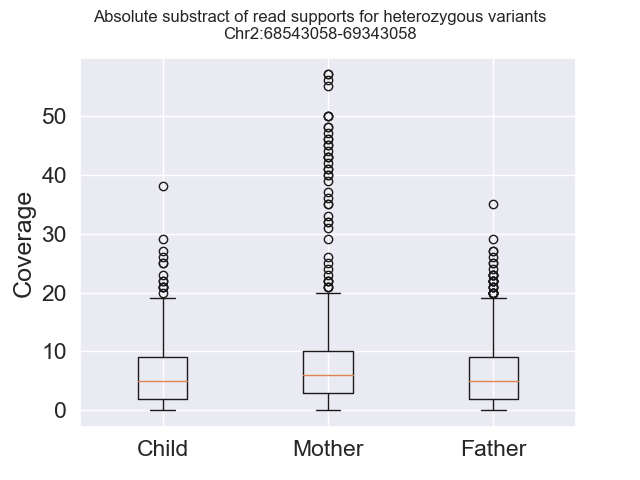

0